In [ ]:
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pyomo.opt import SolverFactory

In [ ]:
# data
data = pd.read_excel('inputs.xlsx')

In [ ]:
def solve_opt(data, pass_min=0, pass_max=5990, mult_1=1, mult_2=1, tee=False): #data, pass_min=0, pass_max=5990, mult_1=1, mult_2=1, tee=False
    model = pyo.ConcreteModel()  # create model
    # vary mult 1 to create pareto front!!!
    t = 96
    k = 100
    D_passenger = (data['Total demand'] * mult_1).tolist()
    O_energy = (data['Outage'] * mult_2).tolist()
    Riding_price = 0.5
    P_buy = 0.1
    P_sell = 0.6
    alpha = 10
    beta = 7.2
    ch_eff = 0.90
    dch_eff = 1/0.9
    gama = 1.5  # 30km/h
    E_0 = 0.2
    E_min = 0.2
    E_max = 1
    R_bat = 150
    C_bat = 80
    Cycle = 3000
    DoD = 60
    T = 96
    delta_t = 0.25

    # sets
    model.T = pyo.RangeSet(t)  # set of timesteps
    model.K = pyo.RangeSet(k)  # set of SAEVs

    # parameters
    model.D_passenger = pyo.Param(model.T, initialize=lambda model, t: D_passenger[t-1])
    model.O_energy = pyo.Param(model.T, initialize=lambda model, t: O_energy[t-1])
    
    # binary variables
    model.b = pyo.Var(model.K, model.T, within=pyo.Binary)  # serving trip indicator
    model.x = pyo.Var(model.K, model.T, domain=pyo.Binary)    # charging indicator
    model.y = pyo.Var(model.K, model.T, domain=pyo.Binary)    # discharging indicator

    # non-negative variables
    model.e = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals)  # energy level of bus k at time t
    model.w_buy = pyo.Var(model.T, within=pyo.NonNegativeReals)  # electricity purchased from the grid at time t
    model.w_sell = pyo.Var(model.T, within=pyo.NonNegativeReals)  # electricity sold to the grid at time t
    model.w_riding = pyo.Var(model.T, within=pyo.NonNegativeReals)  # number of trips performed at time t
    model.d = pyo.Var(model.T, within=pyo.NonNegativeReals)  # total degradation cost of the bus k battery at time t

    # constraints
    model.constraints = pyo.ConstraintList()  # Create a set of constraints

    # Each vehicle can perform at most one action at each timestep
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.b[k, t] + model.x[k, t] + model.y[k, t] <= 1)
            
    # NEW CONSTRAINT: In the first time step, all vehicles should be charging.
    for k in model.K:
        model.constraints.add(model.x[k, 1] == 1)
        model.constraints.add(model.b[k, 1] == 0)
        model.constraints.add(model.y[k, 1] == 0)

    # Constraint for passenger demand (for each time step)
    for t in model.T:
        model.constraints.add(sum(model.b[k, t] for k in model.K) <= model.D_passenger[t])
    
    # The number of trips performed equals the number of vehicles serving at time t
    for t in model.T:
        model.constraints.add(sum(model.b[k, t] for k in model.K) == model.w_riding[t])
    
    # Passenger bounds
    model.constraints.add(sum(model.w_riding[t] for t in model.T) >= pass_min)
    model.constraints.add(sum(model.w_riding[t] for t in model.T) <= pass_max)

    # Energy update constraint for t>=2
    for k in model.K:
        for t in range(2, T + 1):
            model.constraints.add(model.e[k, t] == model.e[k, t-1] + delta_t * ch_eff * alpha * model.x[k, t] 
                                  - gama * model.b[k, t] - delta_t * dch_eff * beta * model.y[k, t])

    # Grid power balance for charging
    for t in model.T:
        model.constraints.add(delta_t * sum(ch_eff * alpha * model.x[k, t] for k in model.K) == model.w_buy[t])
    
    # Grid power balance for discharging
    for t in model.T:
        model.constraints.add(delta_t * sum(dch_eff * beta * model.y[k, t] for k in model.K) == model.w_sell[t])
    
    # Outage power limit
    for t in model.T:
        model.constraints.add(delta_t * sum(dch_eff * beta * model.y[k, t] for k in model.K) <= delta_t * model.O_energy[t])
    
    # Battery energy limits
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.e[k, t] >= C_bat * E_min)
            model.constraints.add(model.e[k, t] <= C_bat * E_max)
    
    # Initial energy level and degradation cost
    for k in model.K:
        model.constraints.add(model.e[k, 1] == E_0 * C_bat)
    for t in model.T:
        model.constraints.add(model.d[t] == (R_bat / (Cycle * DoD)) * model.w_sell[t])

    # objective function
    def rule_obj(mod):
        return (sum(Riding_price * mod.w_riding[t] for t in mod.T) 
                - sum(P_buy * mod.w_buy[t] for t in mod.T) 
                + sum(P_sell * mod.w_sell[t] for t in mod.T)
                - sum(mod.d[t] for t in mod.T))
    model.obj = pyo.Objective(rule=rule_obj, sense=pyo.maximize)
    
    # SOLVER
    opt = pyo.SolverFactory('gurobi')
    opt.options['timelimit'] = 600
    opt.options['mipgap'] = 0.01
    results = opt.solve(model, tee=tee)
    print(results)
    return model


In [89]:
def plot_variables(model, D_passenger, O_energy, t=96, k=100):

    # Minimalist style
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'axes.edgecolor': 'none',
        'axes.grid': False,  # No grid
        'font.size': 13,
        'font.family': 'DejaVu Sans',
        'axes.labelsize': 13,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'legend.fontsize': 11,
        'lines.linewidth': 2,
        'axes.titlepad': 10,
    })

    # Soft pastel palette
    SERVING_COLOR       = "#D37919"
    CHARGING_COLOR      = "#21C875"
    DISCHARGING_COLOR   = "#4198E4"
    IDLE_COLOR          = "#2C2C2C"
    TOTAL_ENERGY_COLOR  = "#3C83E8"
    W_BUY_COLOR         = '#8CD17D'
    W_SELL_COLOR        = '#B6992D'
    PASSENGER_COLOR     = '#499894'
    OUTAGE_COLOR        = '#E15759'

    # Time axis
    time_steps = range(1, t + 1)
    hours = [step / 4 for step in time_steps]
    bar_width = 0.18

    # Model data
    serving = [sum(pyo.value(model.b[k, t]) for k in model.K) for t in model.T]
    charging = [sum(pyo.value(model.x[k, t]) for k in model.K) for t in model.T]
    discharging = [sum(pyo.value(model.y[k, t]) for k in model.K) for t in model.T]
    idle = [k - s - c - d for s, c, d in zip(serving, charging, discharging)]
    total_energy = [sum(pyo.value(model.e[k, t]) for k in model.K) for t in model.T]
    w_buy = [pyo.value(model.w_buy[t]) for t in model.T]
    w_sell = [pyo.value(model.w_sell[t]) for t in model.T]
    serving_percentage = [(sum(pyo.value(model.b[k, t]) for k in model.K) / k) * 100 for t in model.T]
    discharging_percentage = [(sum(pyo.value(model.y[k, t]) for k in model.K) / k) * 100 for t in model.T]

    # Helper for minimalist axes with thin border
    def minimalist(ax):
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color("#000000")
            spine.set_linewidth(0.7)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        ax.tick_params(axis='both', length=0)
        ax.set_facecolor('white')

    # 1. Fleet Status Over Time
    fig, ax = plt.subplots(figsize=(14, 5), dpi=300)
    ax.bar(hours, serving, width=bar_width, color=SERVING_COLOR, label='Serving', alpha=0.85)
    ax.bar(hours, charging, width=bar_width, bottom=serving, color=CHARGING_COLOR, label='Charging', alpha=0.85)
    ax.bar(hours, discharging, width=bar_width, bottom=[s + c for s, c in zip(serving, charging)],
           color=DISCHARGING_COLOR, label='Discharging', alpha=0.85)
    ax.bar(hours, idle, width=bar_width, bottom=[s + c + d for s, c, d in zip(serving, charging, discharging)],
           color=IDLE_COLOR, label='Idle', alpha=0.7)
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Vehicles')
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 1))
    minimalist(ax)
    legend = ax.legend(
        ncol=4,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.25),
        frameon=True,
        framealpha=1,
        edgecolor="#000000"
    )
    legend.get_frame().set_linewidth(0.5)
    fig.tight_layout(pad=1.5)
    plt.show()

    # 2. Total Energy Level of the Fleet
    fig, ax = plt.subplots(figsize=(14, 5), dpi=300)
    ax.plot(hours, total_energy, color=TOTAL_ENERGY_COLOR, label='Total Energy', alpha=0.9)
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Energy [kWh]')
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 1))
    minimalist(ax)
    legend = ax.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, -0.25),
        frameon=True,
        framealpha=1,
        edgecolor="#000000"
    )
    legend.get_frame().set_linewidth(0.5)
    fig.tight_layout(pad=1.5)
    plt.show()

    # 3. Charging and Discharging Power Over Time
    fig, ax = plt.subplots(figsize=(14, 5), dpi=200)
    ax.plot(hours, w_buy, color=W_BUY_COLOR, label='Charging (G2V)', alpha=0.8)
    ax.plot(hours, w_sell, color=W_SELL_COLOR, label='Discharging (V2G)', alpha=0.8)
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Power [kW]')
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 1))
    minimalist(ax)
    legend = ax.legend(
        ncol=2,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.25),
        frameon=True,
        framealpha=1,
        edgecolor="#000000"
    )
    legend.get_frame().set_linewidth(0.5)
    fig.tight_layout(pad=1.5)
    plt.show()

    # 4. Vehicles Serving (%) vs Passenger Demand
    fig, ax1 = plt.subplots(figsize=(14, 5), dpi=300)
    ax1.bar(hours, serving_percentage, width=bar_width, color=SERVING_COLOR, label='Serving (%)', alpha=0.8)
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Vehicles [%]')
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 1))
    minimalist(ax1)
    ax2 = ax1.twinx()
    ax2.plot(hours, D_passenger, color=PASSENGER_COLOR, linestyle='-', label='Passenger Demand', alpha=0.7)
    ax2.set_ylabel('Passengers')
    minimalist(ax2)
    ax2.spines['left'].set_visible(False)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    legend = ax1.legend(
        lines_1 + lines_2,
        labels_1 + labels_2,
        ncol=2,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.25),
        frameon=True,
        framealpha=1,
        edgecolor="#000000"
    )
    legend.get_frame().set_linewidth(0.5)
    fig.tight_layout(pad=1.5)
    plt.show()

    # 5. Vehicles Discharging (%) vs Outage Demand
    fig, ax1 = plt.subplots(figsize=(14, 5), dpi=300)
    ax1.bar(hours, discharging_percentage, width=bar_width, color=DISCHARGING_COLOR, label='Discharging (%)', alpha=0.8)
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Vehicles [%]')
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 1))
    minimalist(ax1)
    ax2 = ax1.twinx()
    ax2.plot(hours, O_energy, color=OUTAGE_COLOR, linestyle='-', label='Outage Demand', alpha=0.7)
    ax2.set_ylabel('Power [kW]')
    minimalist(ax2)
    ax2.spines['left'].set_visible(False)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    legend = ax1.legend(
        lines_1 + lines_2,
        labels_1 + labels_2,
        ncol=2,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.25),
        frameon=True,
        framealpha=1,
        edgecolor="#000000"
    )
    legend.get_frame().set_linewidth(0.5)
    fig.tight_layout(pad=1.5)
    plt.show()

    # 6. Vehicles Serving vs Power Delivered to the Grid
    fig, ax1 = plt.subplots(figsize=(14, 5), dpi=300)
    ax1.bar(hours, serving, width=bar_width, color=SERVING_COLOR, label='Serving', alpha=0.8)
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Vehicles')
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 1))
    minimalist(ax1)
    ax2 = ax1.twinx()
    ax2.plot(hours, w_sell, color=W_SELL_COLOR, linestyle='-', label='Power Delivered (V2G)', alpha=0.7)
    ax2.set_ylabel('Power [kW]')
    minimalist(ax2)
    ax2.spines['left'].set_visible(False)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    legend = ax1.legend(
        lines_1 + lines_2,
        labels_1 + labels_2,
        ncol=2,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.25),
        frameon=True,
        framealpha=1,
        edgecolor="#000000"
    )
    legend.get_frame().set_linewidth(0.5)
    fig.tight_layout(pad=1.5)
    plt.show()

def save_to_excel(model, filename='output.xlsx'):
	# Extract variables of interest
	T = list(model.T)
	K = list(model.K)
	# Serving, charging, discharging, energy, w_buy, w_sell
	serving = [sum(pyo.value(model.b[k, t]) for k in K) for t in T]
	charging = [sum(pyo.value(model.x[k, t]) for k in K) for t in T]
	discharging = [sum(pyo.value(model.y[k, t]) for k in K) for t in T]
	total_energy = [sum(pyo.value(model.e[k, t]) for k in K) for t in T]
	w_buy = [pyo.value(model.w_buy[t]) for t in T]
	w_sell = [pyo.value(model.w_sell[t]) for t in T]

	df = pd.DataFrame({
		'TimeStep': T,
		'Serving': serving,
		'Charging': charging,
		'Discharging': discharging,
		'TotalEnergy': total_energy,
		'W_buy': w_buy,
		'W_sell': w_sell
	})
	df.to_excel(filename, index=False)
	print(f"Results saved to {filename}")

In [93]:
model = solve_opt(data,pass_min=2000, mult_2=0,tee=True) # vary pass_min=2000 mult_2=0 (transportation scenario) / pass_min=0 mult_2=1 (outage scenario)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Read LP format model from file /var/folders/bs/tqpdfpm95n9c4cp994_d9lm00000gn/T/tmpz_7uum3e.pyomo.lp
Reading time = 0.14 seconds
x1: 39278 rows, 38784 columns, 144572 nonzeros
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[rosetta2] - Darwin 24.3.0 24D81)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 39278 rows, 38784 columns and 144572 nonzeros
Model fingerprint: 0x7946a963
Variable types: 9984 continuous, 28800 integer (28800 binary)
Coefficient statistics:
  Matrix range     [8e-04, 2e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+04]
Presolve removed 20382 rows and 10390 columns
Presolve time: 0.12s
Presolved: 18896 rows, 28394 columns, 66082 nonzeros
Variable types: 0 continuous, 

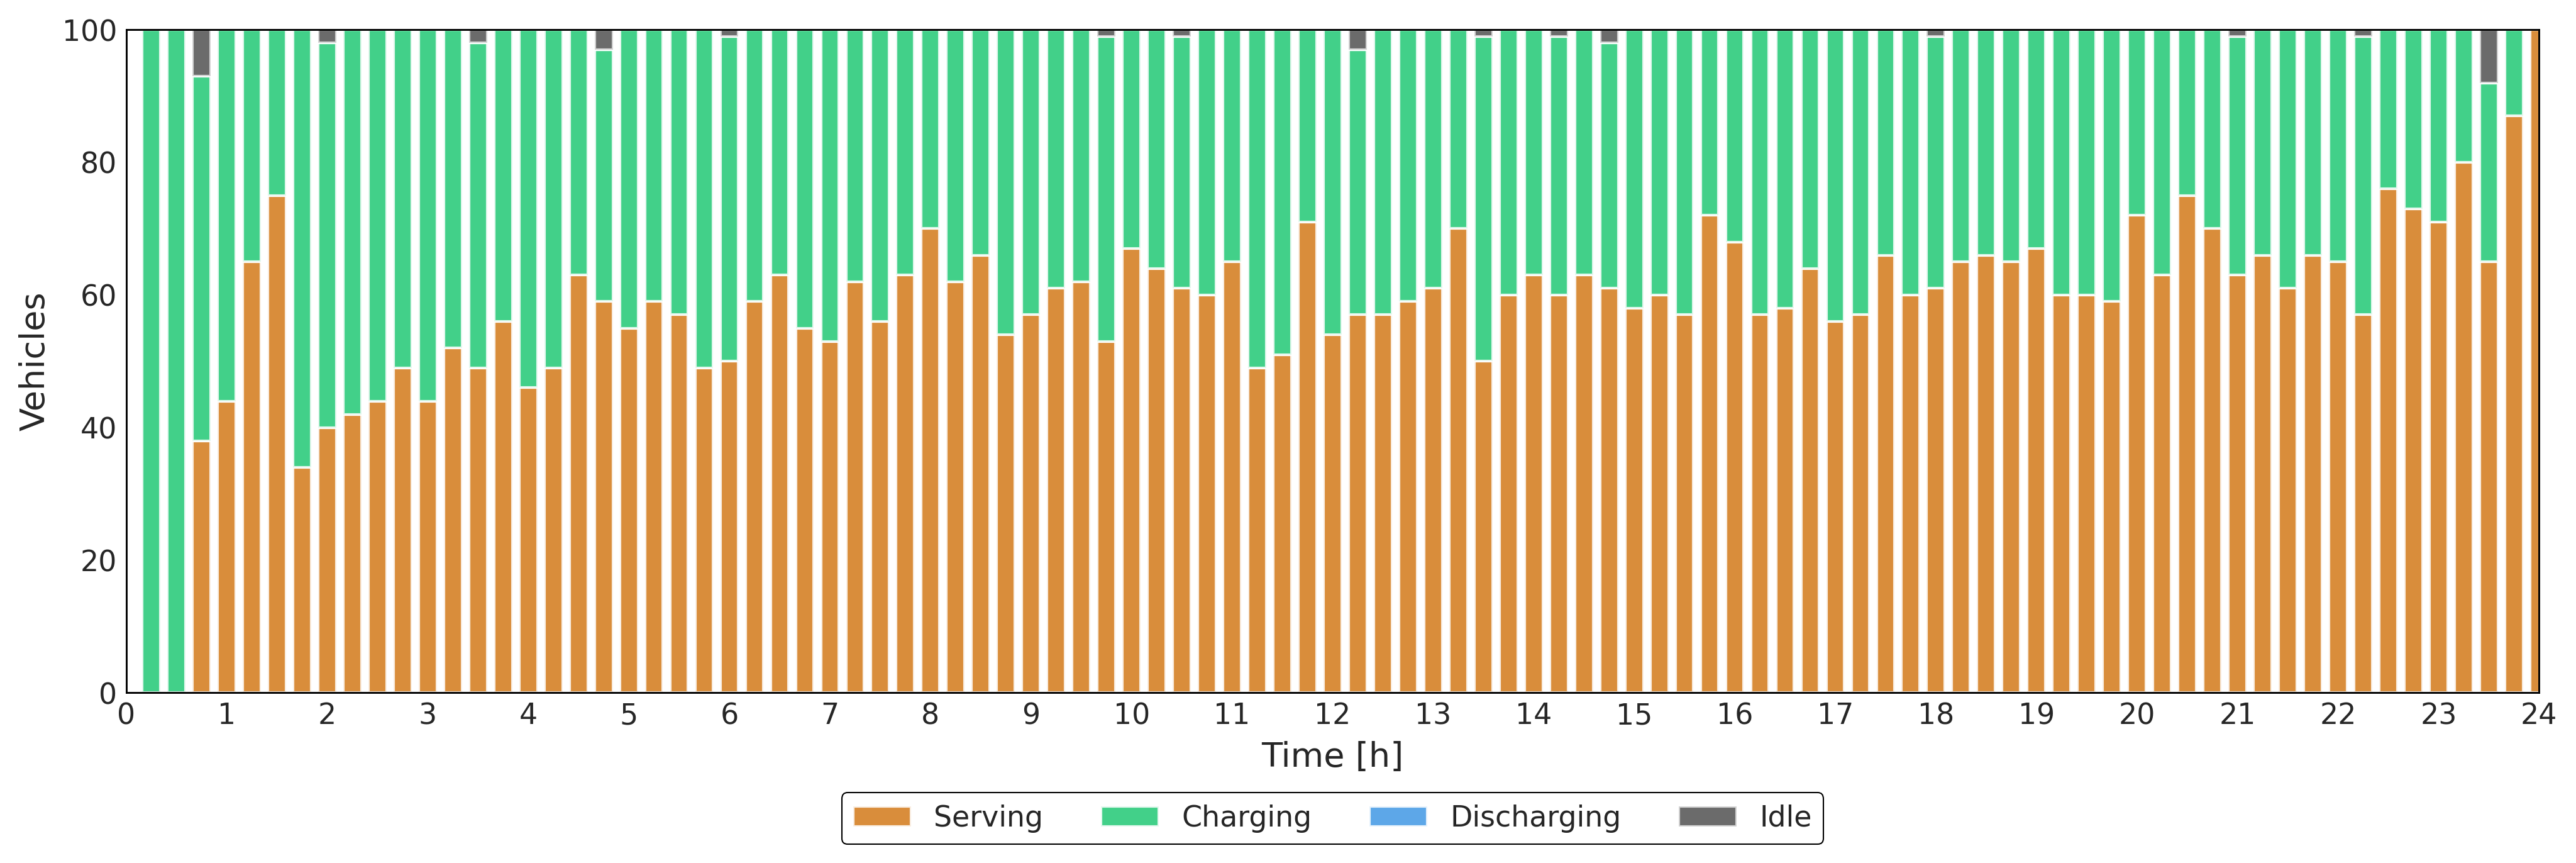

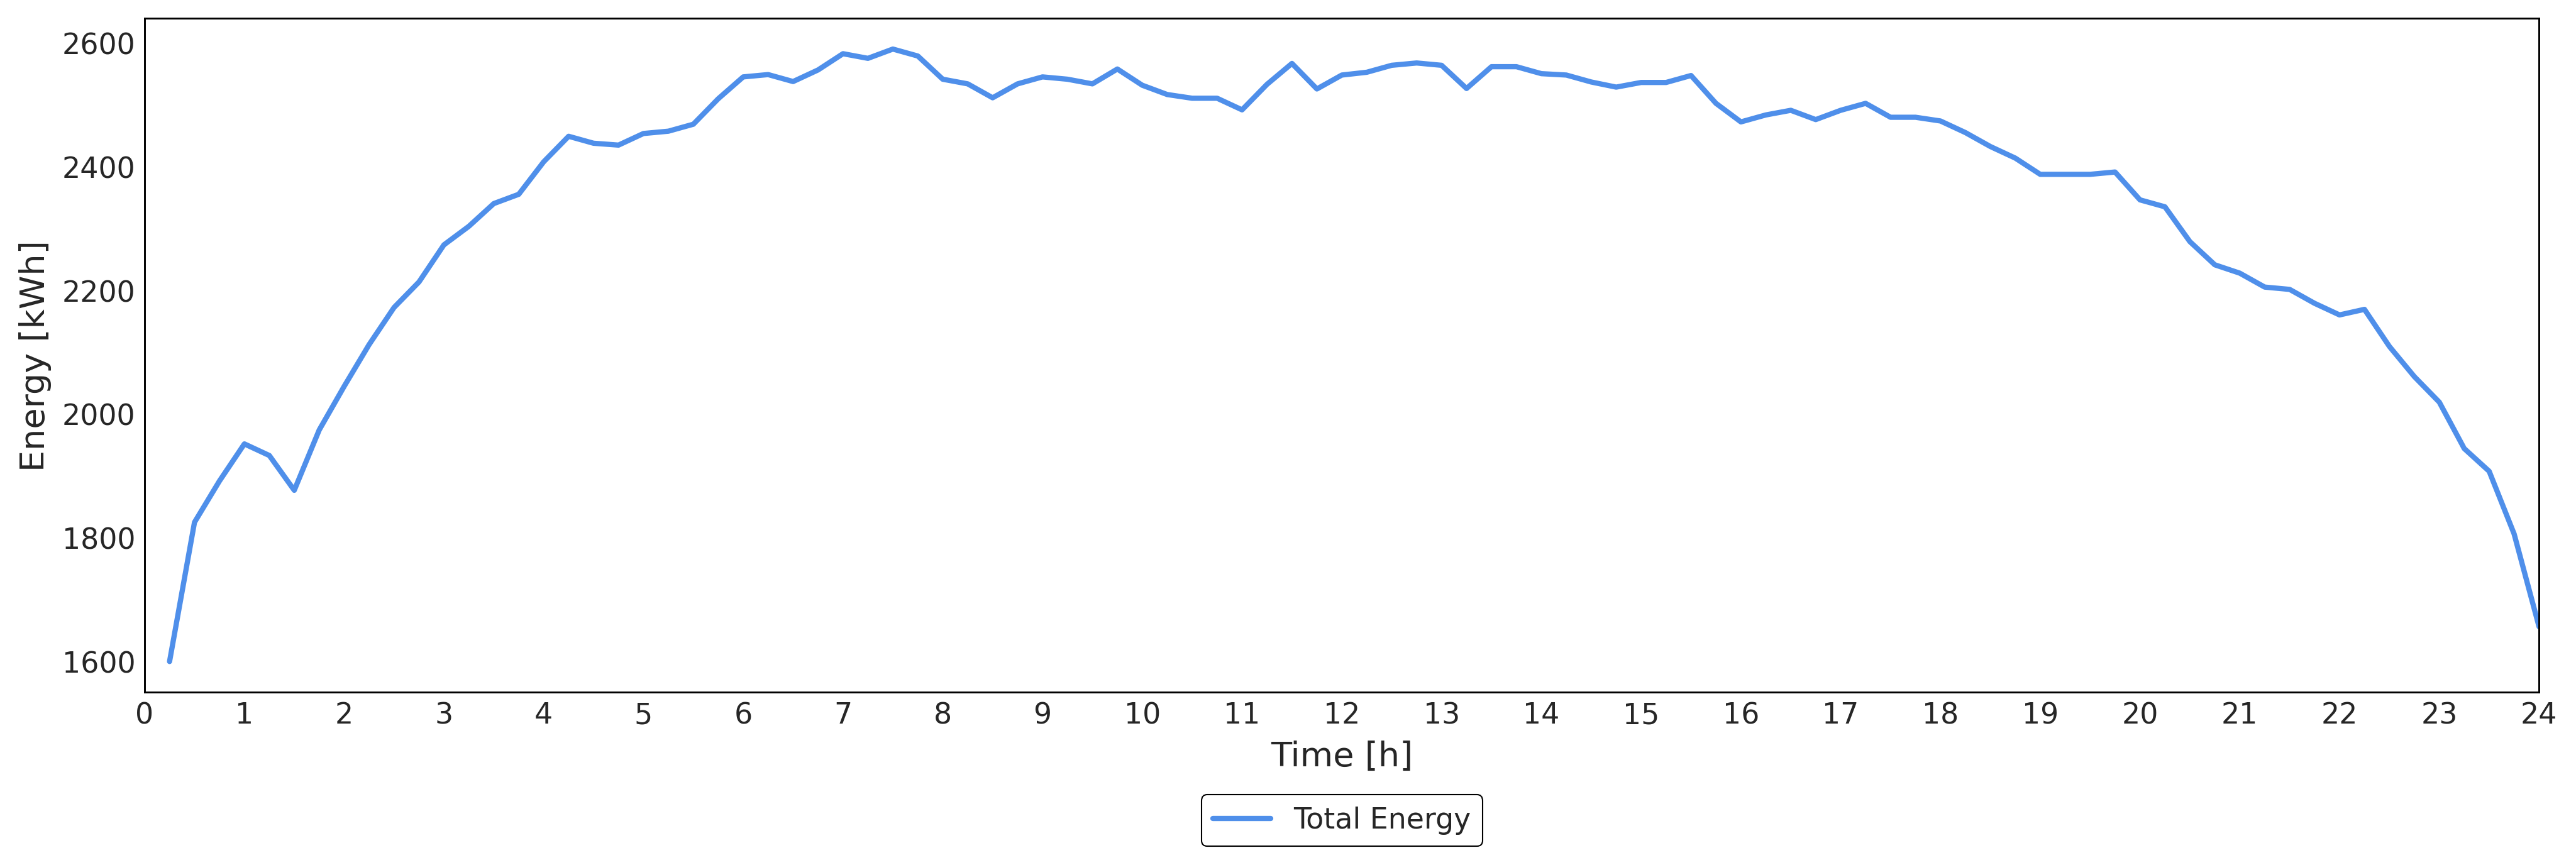

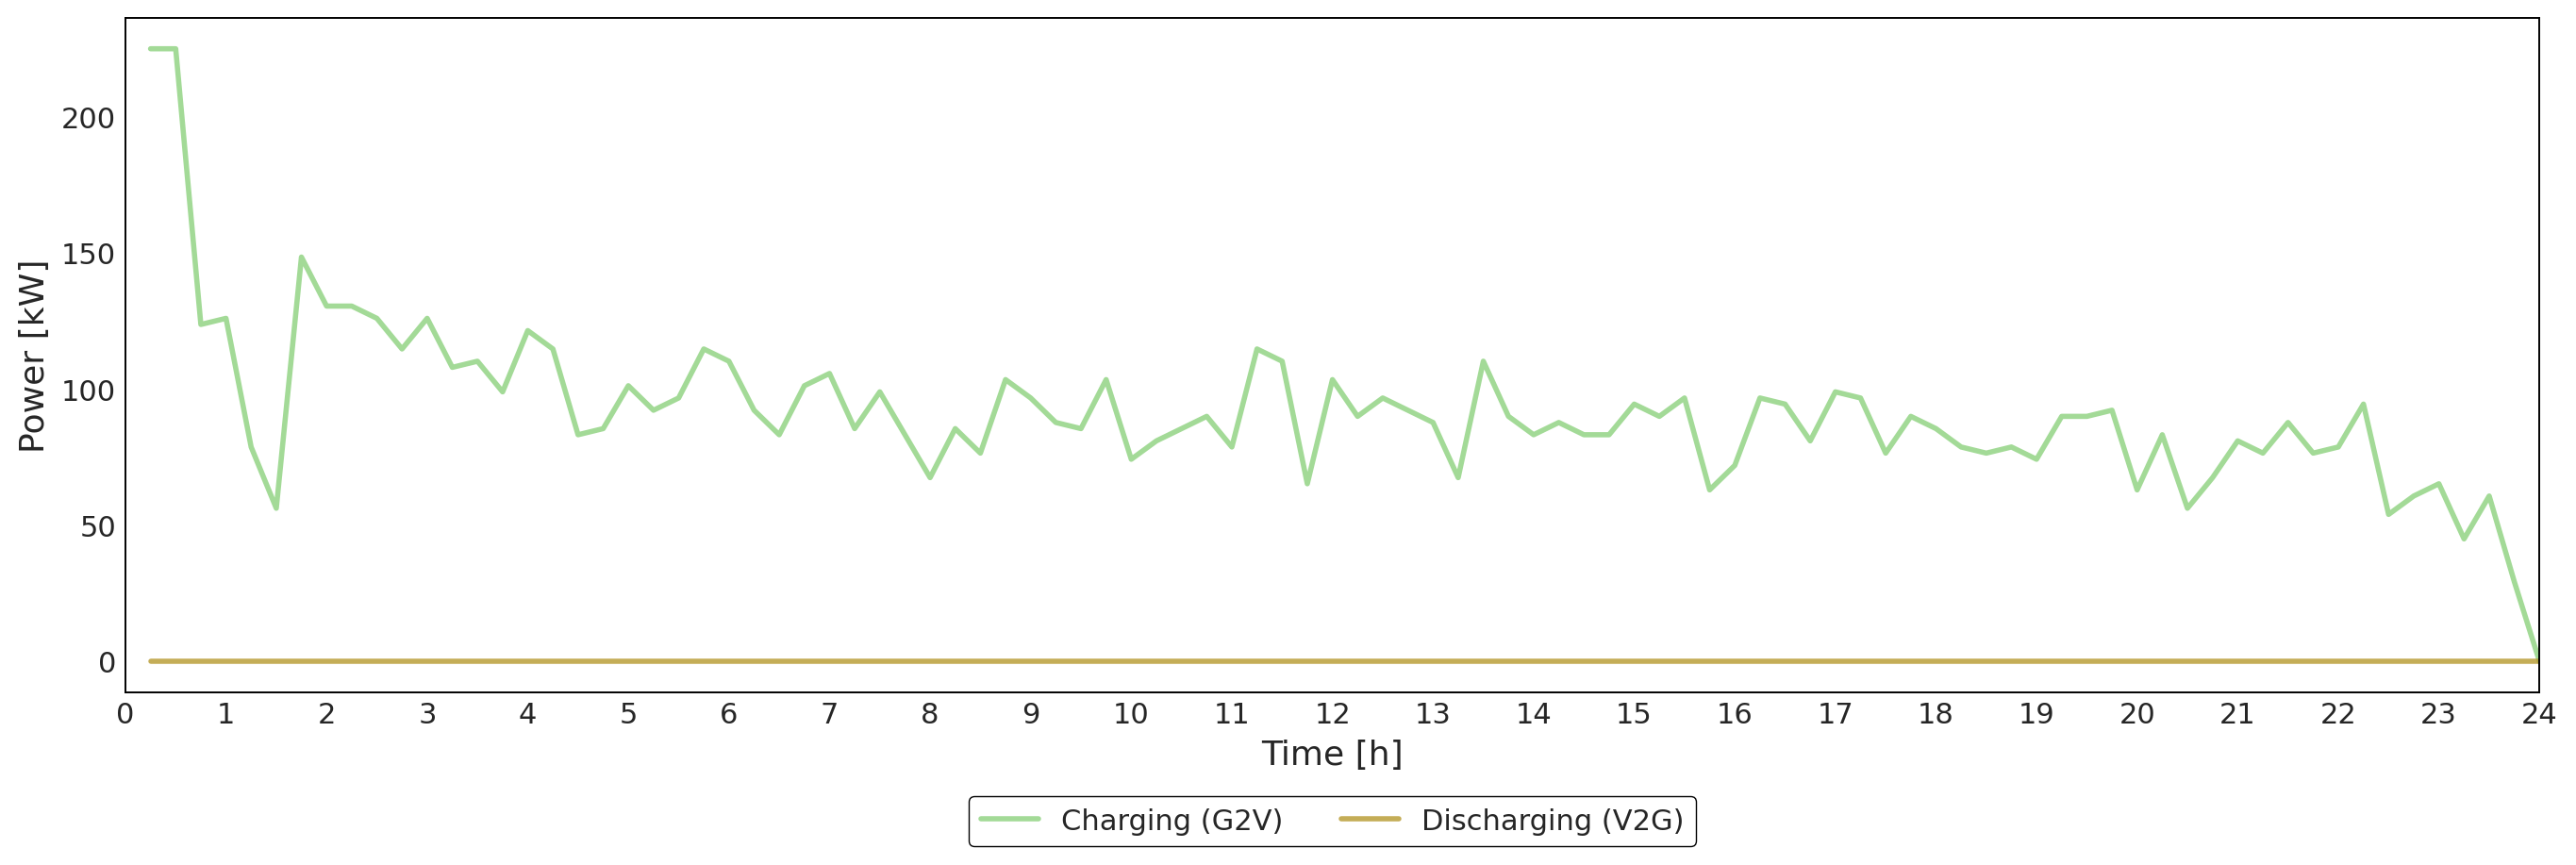

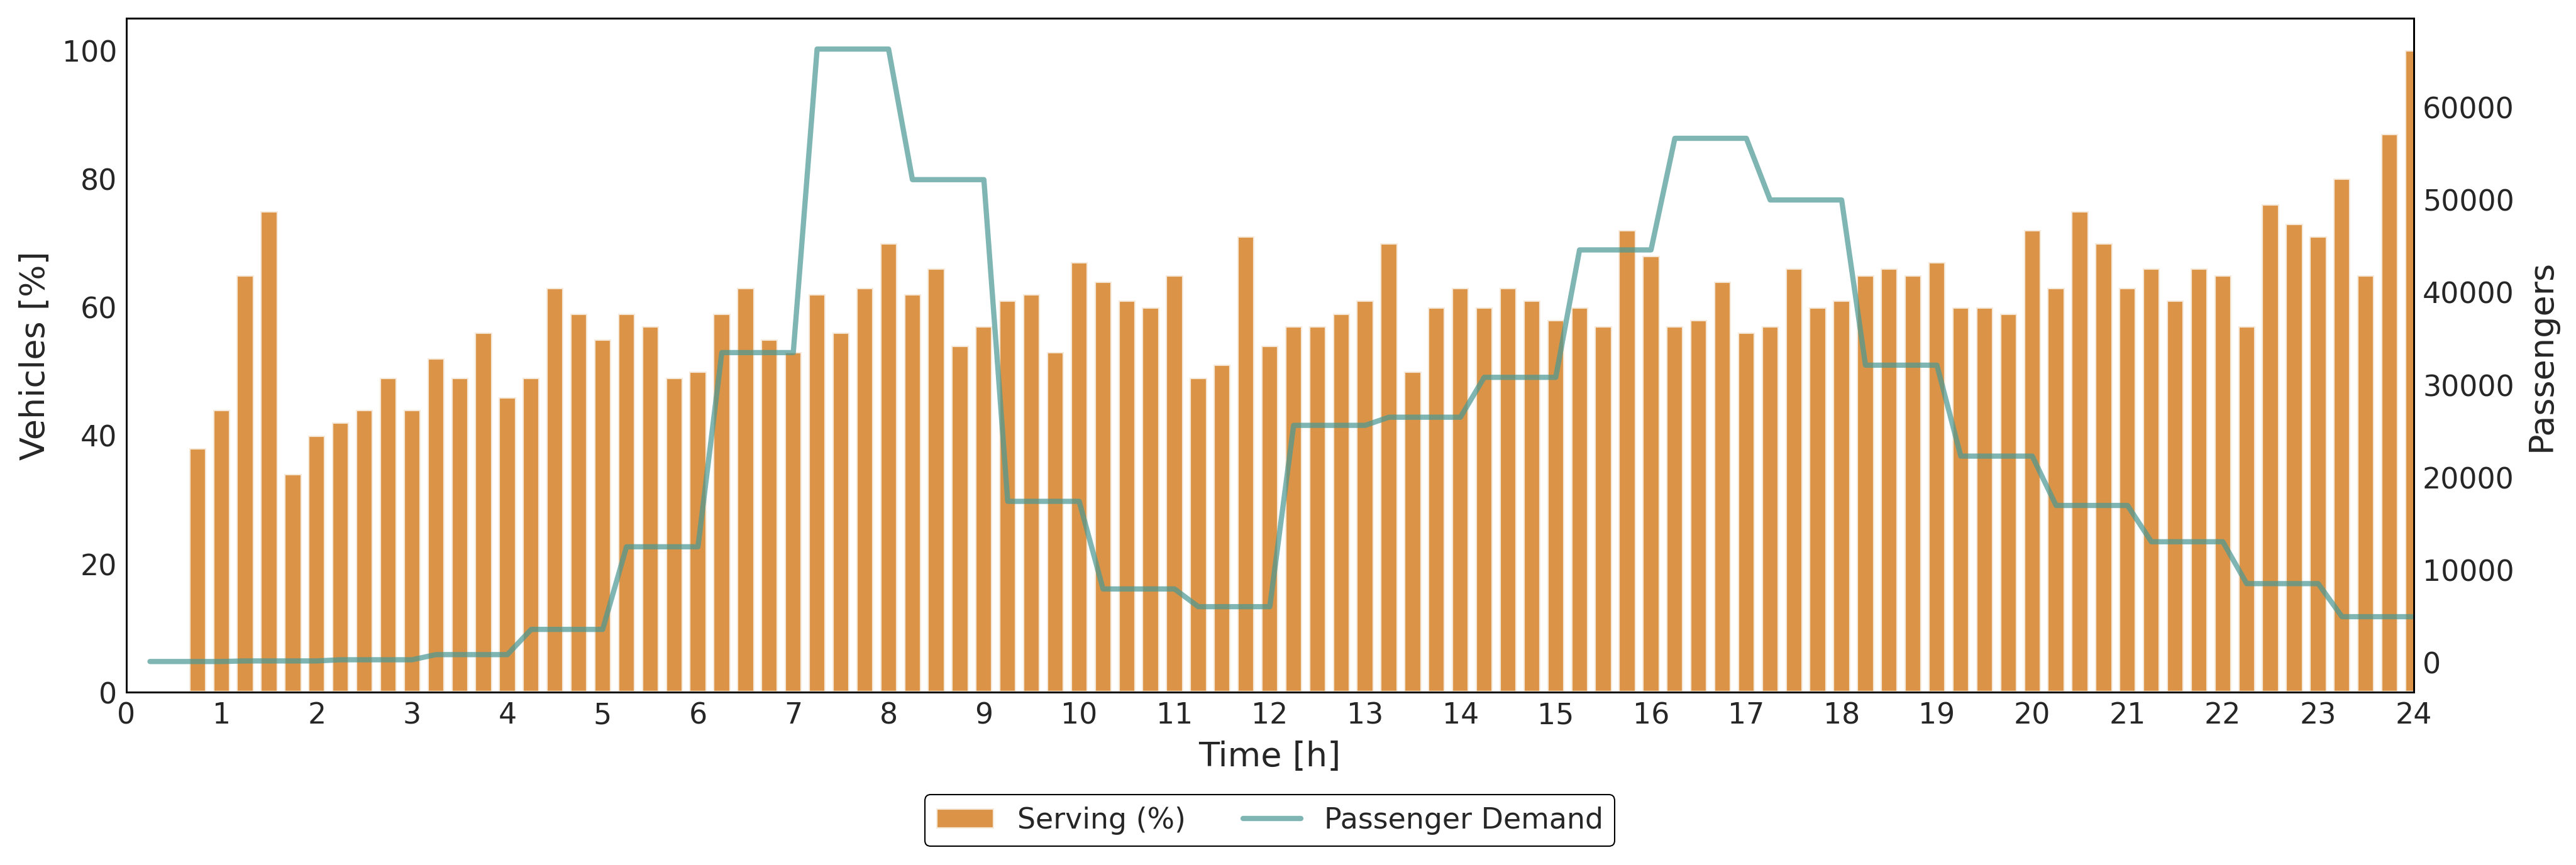

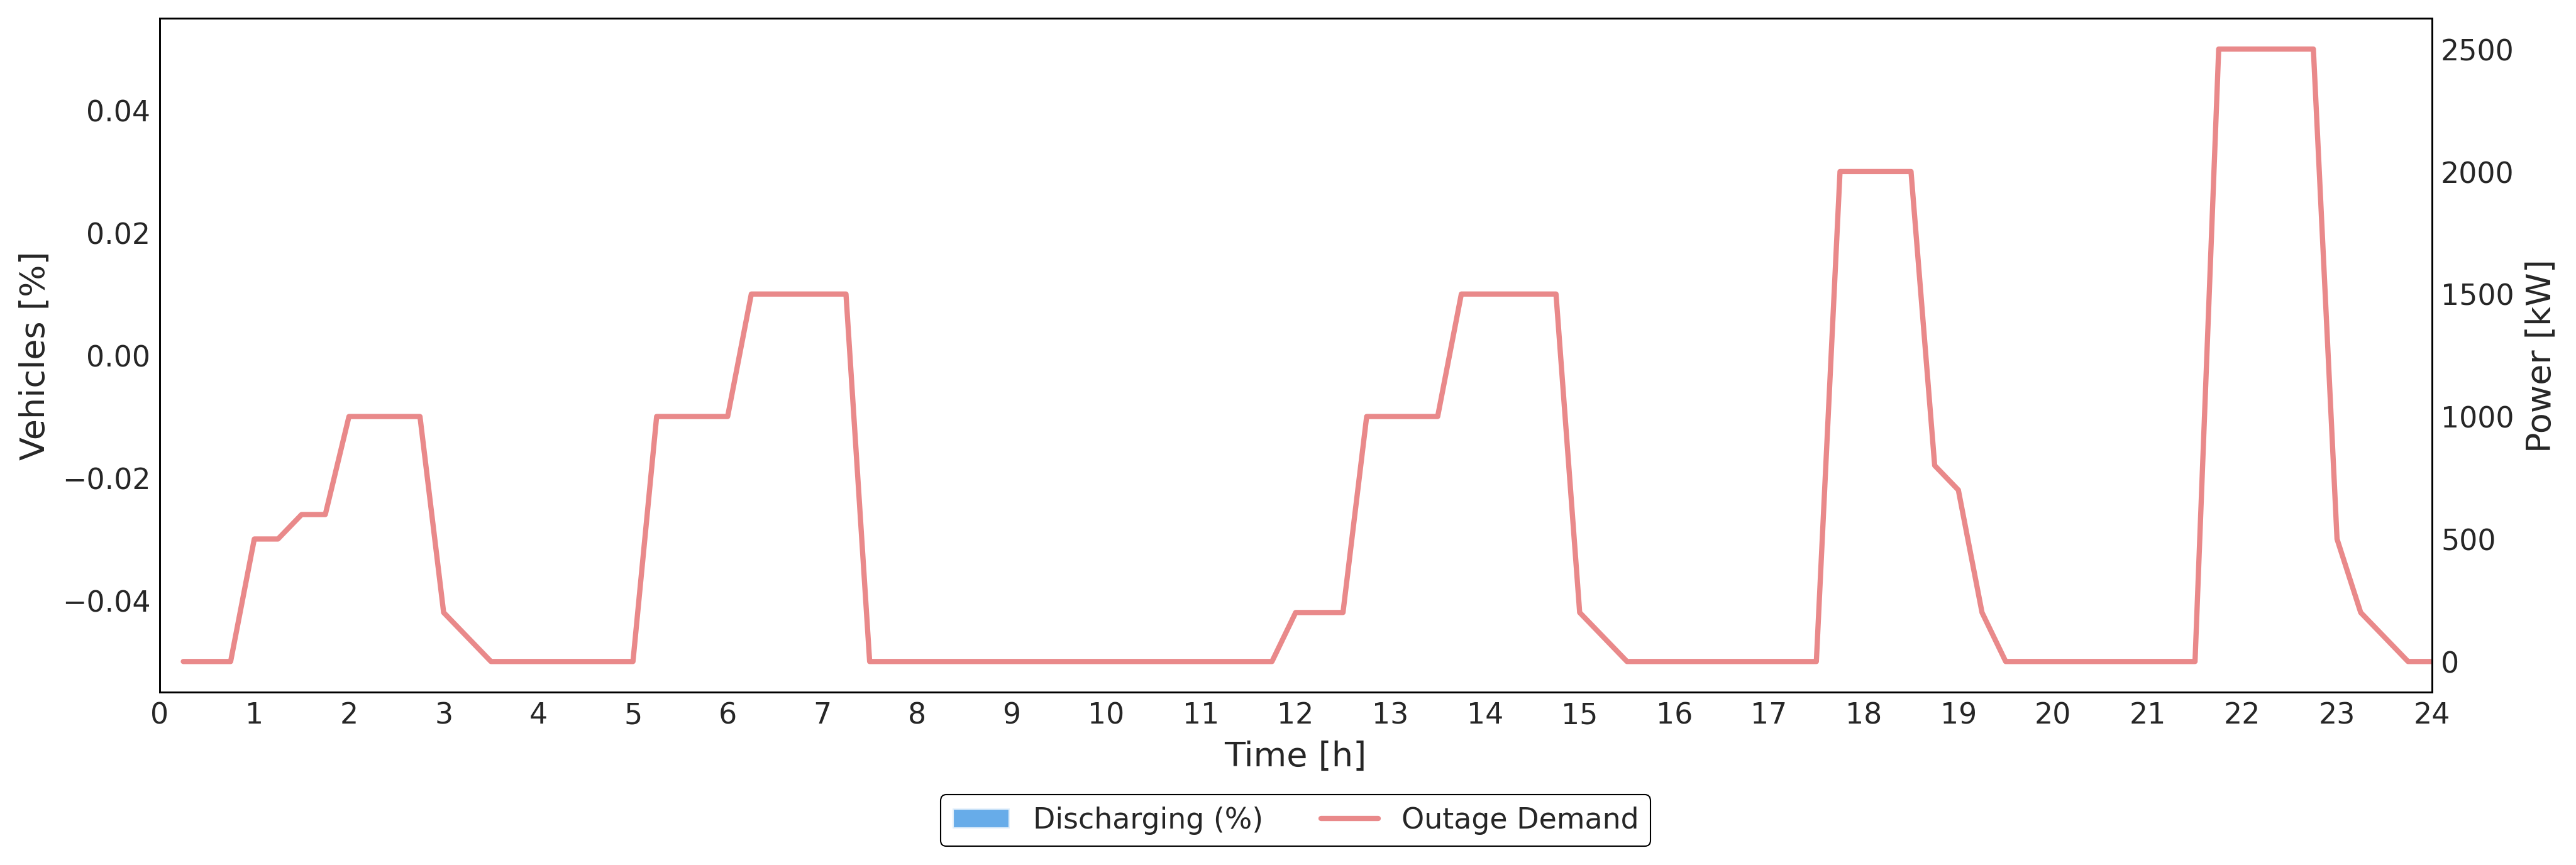

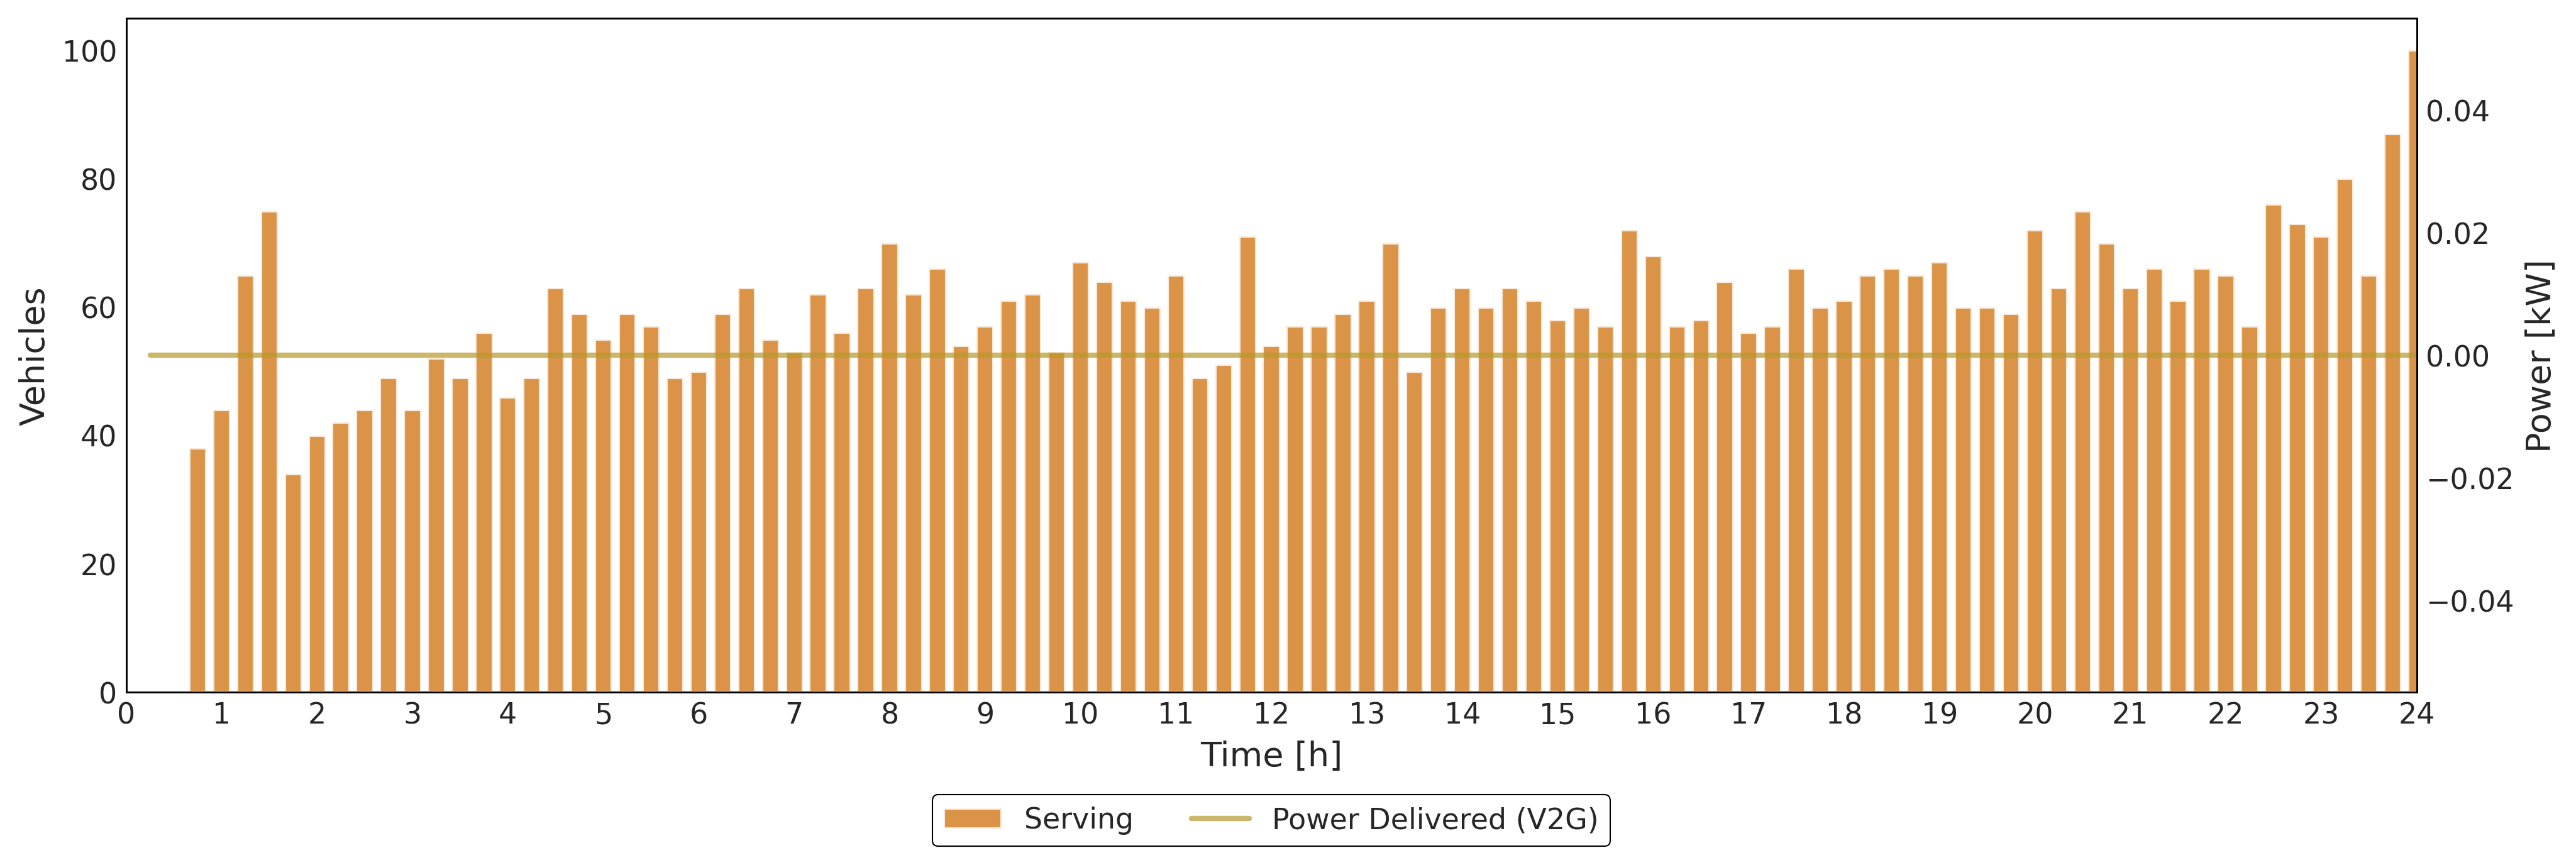

In [94]:
D_passenger = (data['Total demand'][:96]).tolist()
O_energy = (data['Outage'][:96]).tolist()
plot_variables(model, D_passenger, O_energy)

In [95]:
# Create a dynamic filename
filename = 'output_energy.xlsx'
# Save results to Excel
save_to_excel(model, filename=filename)

Results saved to output_energy.xlsx
